In [18]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

import sys
import numpy as np
import time
import matplotlib
matplotlib.rcParams['contour.negative_linestyle']= 'solid'
import matplotlib.pyplot as plt
import matplotlib.patches as Polygon
import copy as cp
import cmocean
import glob 
import xarray

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_moc   import *
from colormap_c2c    import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'        ] = False
inputarray['save_figpath'    ] = '/home/ollie/pscholz/figures/paper_fesom2.0/'

# inputarray['mesh_id'		 ] = 'COREv2'
# inputarray['mesh_dir'		 ] = '/work/ollie/pscholz/mesh_fesom2.0/mesh_CORE2_finaltopo_mean/'

#inputarray['mesh_id'		 ] = 'nemo'
#inputarray['mesh_dir'		 ] = '/work/ollie/nkolduno/meshes/NEMO_RT/'
#inputarray['mesh_rotate'	 ] = False

#inputarray['mesh_id'		 ] = 'bold'
#inputarray['mesh_dir'		 ] = '/work/ollie/nkolduno/meshes/bold_mesh/'
#inputarray['mesh_rotate'	 ] = False

#inputarray['mesh_id'		 ] = 'fron'
#inputarray['mesh_dir'		 ] = '/work/ollie/nkolduno/meshes/fron_2.0_RTopo/'
#inputarray['mesh_rotate'	 ] = False

inputarray['mesh_id'		 ] = 'storm'
inputarray['mesh_dir'		 ] =  '/work/ollie/nkolduno/meshes/STORM2/'
inputarray['mesh_rotate'	 ] = False

try:
	mesh
except NameError:
	mesh = fesom_init_mesh(inputarray)
else:
    if mesh.id!=inputarray['mesh_id']:
        mesh = fesom_init_mesh(inputarray)
    else:
        print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   


___LOAD FESOM MESH storm_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=5576658
     > elem2d.out : #2de=11095119
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> remove cyclic boundary
_______________________________________________________________


# Calculate Meridional Overturning Circulation Profile

Use for the calculation of the Meridional Overturning Circulation (MOC) the equation for the calculation of the "Pseudostreamfunction". Condition for the calculation of the regional MOC (i.e AMOC, PMOC, IMOC) is that the domain over which the caluclation is carried out, is approximately sorounded by a coast (Bering Strait can be accouted as coast its just 30m deep). Since Atlantic, Pacific and Indian Ocean have no southern coastal boundary the AMOC and PMOC can just be calculated until -30°S and the meridional cumulativ integration has to be carried out from North to South instead South to North which leads to an additional minus sign in the calcualtion (see: sub_fesom_moc.py, line:137)
$${\int_E^W w(x',y,z) dx' = {{\partial\Psi} \over {\partial y}}}$$
$$ \textrm{GMOC:} ~~~  {\Psi(y,z) = \int_S^N {\int_E^W w(x',y',z) \cdot dx'} dy'} ~~$$
$$ \textrm{AMOC:} ~~~  {\Psi(y,z) = -\int_N^{-30S^\circ} {\int_E^W w(x',y',z) \cdot dx'} dy'} $$
$$ \textrm{PMOC:} ~~~  {\Psi(y,z) = -\int_{Bering Strait} ^{-30S^\circ} {\int_E^W w(x',y',z) \cdot dx'} dy'} $$

In [4]:
#%%prun -s cumulative -q -l 100 -D profile.bin
#____________________________________________________________________________________________________
# load vertical velocity data
data1 		 	= fesom_data(inputarray) 
#data1.descript,data1.path = 'linfs' ,'../results/linfs/zmeanval/3/'
#data1.descript,data1.path = 'bold' ,'/work/ollie/ogurses/output_BOLD_RT/'
#data1.descript,data1.path = 'fron' , '/work/ollie/ogurses/output_FRON/'
data1.descript,data1.path,data1.runid = 'storm', '/work/ollie/ogurses/output_STORM_RT/','storm'
#data1.descript,data1.path = 'nemo' , '/work/ollie/ogurses/NEMO_RT/'

data1.var 		= 'w'
data1.year		= [1998,1999]
data1.cmap      = 'blue2red'
data1.month		= [1,2,3,4,5,6,7,8,9,10,11,12]
fesom_load_data3d_4bm(mesh,data1,do_output=True)


     -----+-----------------------------------+------------
     Year |               MON                 |
     -----+-----------------------------------+------------
     --> /work/ollie/ogurses/output_STORM_RT/
     --> w
     1998 |01|02|03|04|05|06|07|08|09|10|11|12| --> t=312.11s
     1999 |01|02|03|04|05|06|07|08|09|10|11|12| --> t=308.88s


_____calc. GMOC from vertical velocities via meridional bins_____
 --> total time:38.360 s


<IPython.core.display.Javascript object>


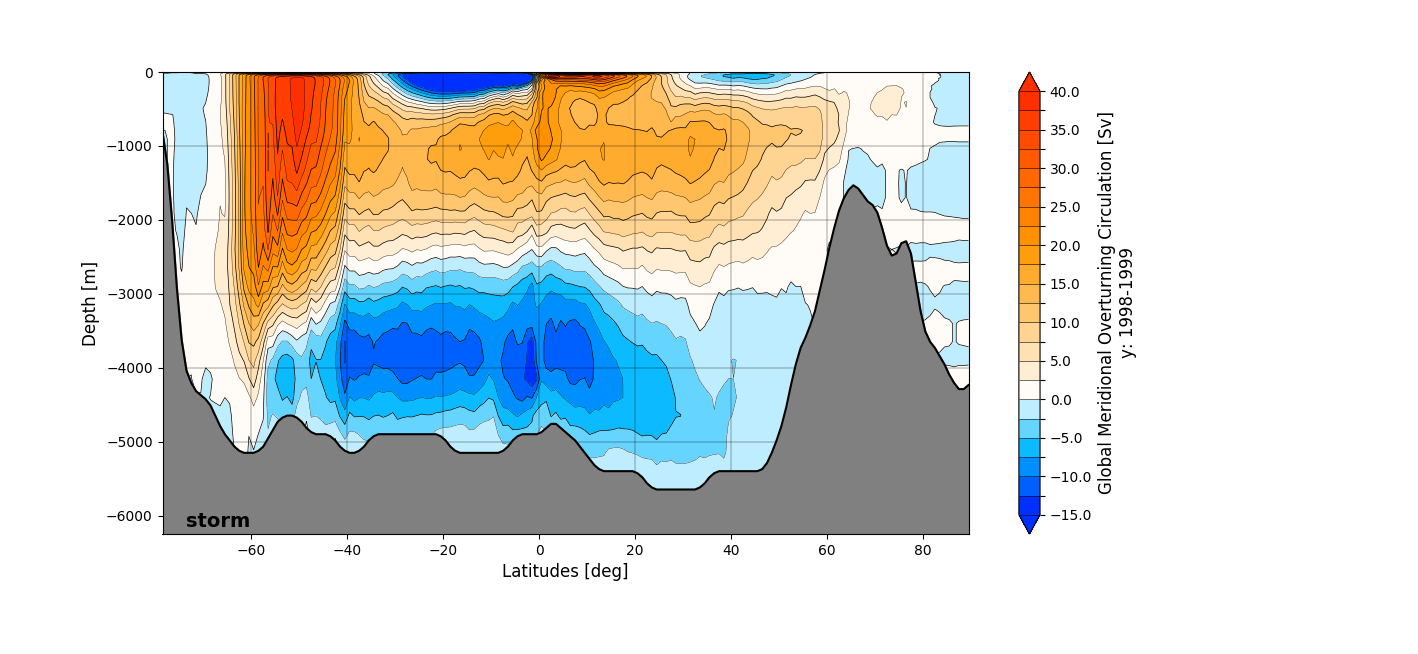

_____calc. AMOC from vertical velocities via meridional bins_____
 --> change mesh focus
 --> remove cyclic boundary
 --> calculate basin limited domain >> use rtracing parallel  >> time: 23.751 s


<IPython.core.display.Javascript object>


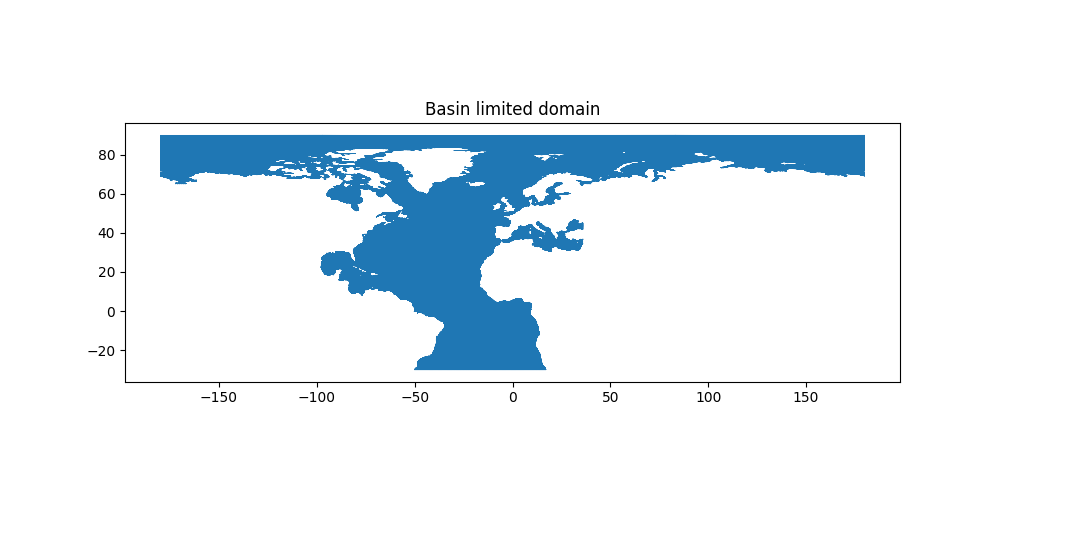

 --> total time:45.565 s


<IPython.core.display.Javascript object>


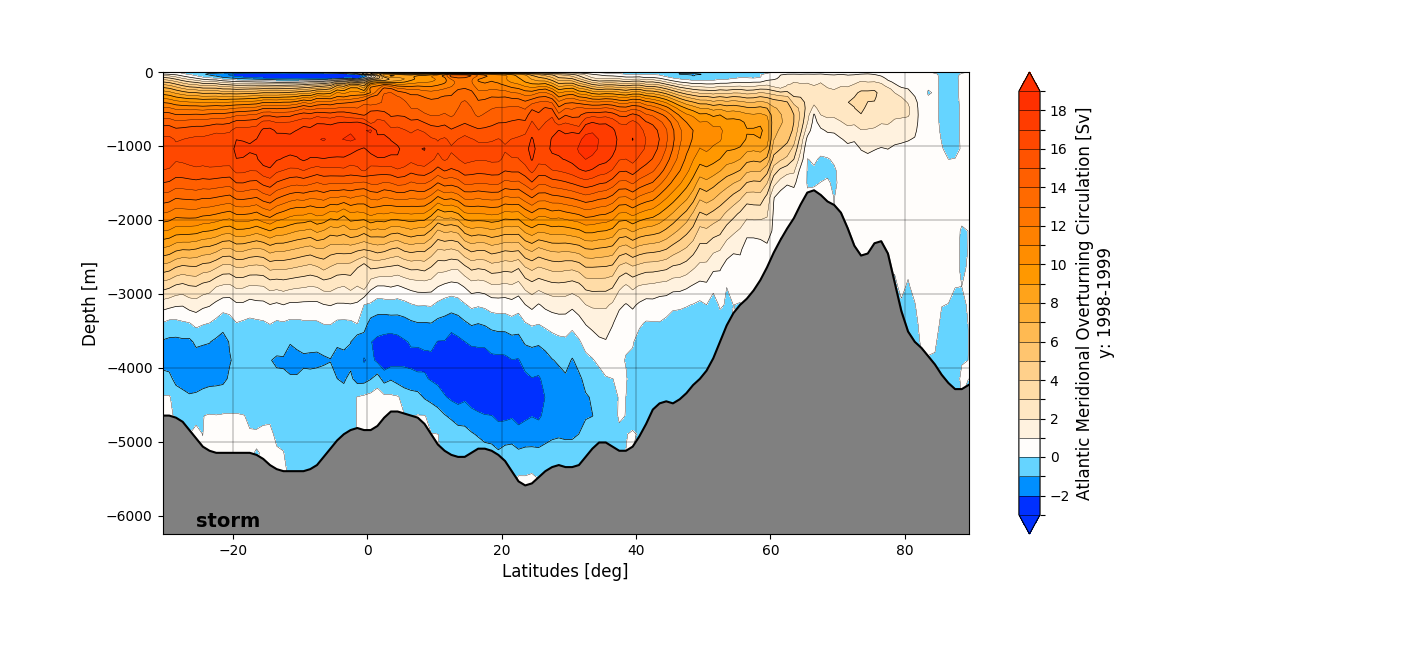

_____calc. PMOC from vertical velocities via meridional bins_____
 --> change mesh focus
 --> remove cyclic boundary
 --> calculate basin limited domain >> use rtracing parallel 

In [ ]:
#%%prun -s cumulative -q -l 100 -D profile.bin #write out profile file usable with snakeviz profile.bin
#____________________________________________________________________________________________________
#select XMOC
which_moc = 'gmoc'

#____________________________________________________________________________________________________
# calc XMOC
moc1,lat,bottom,elemidx  = calc_xmoc(mesh,data1,which_moc=which_moc,out_elemidx=True)
#moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc,in_elemidx=elemidx)

# moc1,lat,bottom,elemidx  = calc_xmoc(mesh,data1,which_moc=amoc,out_elemidx=True)
# --> writes out elem index to use for AMOC or PMOC can be directly read into next calucation of amoc 
# --> moc2,lat,bottom      =calc_xmoc(mesh,data2,which_moc=amoc,in_elemidx=elemidx)
#____________________________________________________________________________________________________
# plot XMOC
fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)

#____________________________________________________________________________________________________
# save XMOC
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    str_times= data1.str_time.replace(' ','').replace(':','') 
    sdname, sfname = inputarray['save_figpath'], 'plot_'+data1.descript+'_'+which_moc+'_'+str_times+'.png'
    plt.savefig(sdname+sfname, format='png', dpi=600, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)
    
#____________________________________________________________________________________________________    
# which_moc = 'amoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
# which_moc = 'pmoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
# which_moc = 'imoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)

# Calculate Meridional Overturning Circulation Time-Series

In [ ]:
stop
which_moc='amoc'
# which_lat=[26.0, 35.0, 40.0,'max']
which_lat=['max']
#____________________________________________________________________________________________________
# load vertical velocity data
# data1 		 	= fesom_data(inputarray) 
# data1.descript  = 'zstar'
# data1.path      = '../results/'+data1.descript+'_pgf/'+'/withoutPC-2/'
# data1.var 		= 'w'
# data1.year		= [1948,2009]
# data1.month		= [1,2,3,4,5,6,7,8,9,10,11,12]

#____________________________________________________________________________________________________
# calc MOC time-series
count=0
print(' --> CALC YEAR:')
moc_t = np.zeros((data1.year[1]-data1.year[0]+1,len(which_lat)))
time  = np.zeros((data1.year[1]-data1.year[0]+1,))
datayr=cp.deepcopy(data1)
for year in range(data1.year[0],data1.year[1]+1):
    #_______________________________________________________________________________________________
    print('|'+str(year),end='')
    if np.mod(count+1,10)==0: print('|')
    #_______________________________________________________________________________________________
    datayr.year		= [year,year]
    fesom_load_data_horiz(mesh,datayr,do_output=False)
    if count==0:
        moc_prof,lat,bottom,elemidx  = calc_xmoc(mesh,datayr,which_moc=which_moc,out_elemidx=True,do_output=False)
    else:
        moc_prof,lat,bottom  = calc_xmoc(mesh,datayr,which_moc=which_moc,in_elemidx=elemidx,do_output=False)
    #_______________________________________________________________________________________________
    moc_d=moc_prof[np.where(mesh.zlev<=-500)[0],:]
    count_lat=0
    for lati in which_lat:
        if lati=='max':
            moc_l= moc_d[:,np.where((lat>=30) & (lat<=45))[0]]
        else:
            moc_l= moc_d[:,np.where(lat>=lati)[0][0]]
        moc_t[count,count_lat]=moc_l.max()
        count_lat=count_lat+1
    time[count]=year    
    count=count+1
    
#____________________________________________________________________________________________________
# plot MOC time-series
fig,ax=plot_xmoc_tseries(time,moc_t,which_lat,which_moc)    